In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
from TALENT.model.models import tabr

In [2]:
def load_dataset(dataset_name, data_dir="data"):  # из 1ой задачи
    dataset_path = os.path.join(data_dir, dataset_name)

    with open(os.path.join(dataset_path, "info.json"), "r") as f:
        info = json.load(f)

    task_type = info["task_type"]
    n_num_features = info["n_num_features"]
    n_cat_features = info["n_cat_features"]

    data_dict = {
        "info": info,
        "task_type": task_type,
        "n_num_features": n_num_features,
        "n_cat_features": n_cat_features
    }

    if n_num_features > 0:
        data_dict["N_train"] = np.load(os.path.join(dataset_path, "N_train.npy"))
        data_dict["N_val"] = np.load(os.path.join(dataset_path, "N_val.npy"))
        try:
            data_dict["N_test"] = np.load(os.path.join(dataset_path, "N_test.npy"))
        except FileNotFoundError:
            data_dict["N_test"] = None

    if n_cat_features > 0:
        data_dict["C_train"] = np.load(os.path.join(dataset_path, "C_train.npy"))
        data_dict["C_val"] = np.load(os.path.join(dataset_path, "C_val.npy"))
        try:
            data_dict["C_test"] = np.load(os.path.join(dataset_path, "C_test.npy"))
        except FileNotFoundError:
            data_dict["C_test"] = None

    data_dict["y_train"] = np.load(os.path.join(dataset_path, "y_train.npy"))
    data_dict["y_val"] = np.load(os.path.join(dataset_path, "y_val.npy"))
    try:
        data_dict["y_test"] = np.load(os.path.join(dataset_path, "y_test.npy"))
    except FileNotFoundError:
        data_dict["y_test"] = None

    return data_dict

In [3]:
def prepare_tabr_data(data_dict, device="cuda" if torch.cuda.is_available() else "cpu"):  # для подготовки данных
    n_num_features = data_dict["n_num_features"]
    n_cat_features = data_dict["n_cat_features"]
    task_type = data_dict["task_type"]

    prepared_data = {
        "task_type": task_type,
        "n_num_features": n_num_features,
        "n_cat_features": n_cat_features
    }

    if n_num_features > 0:
        # Стандартизируем numeric фичи
        scaler = StandardScaler()
        N_train_scaled = scaler.fit_transform(data_dict["N_train"])
        N_val_scaled = scaler.transform(data_dict["N_val"])

        prepared_data["N_train"] = torch.FloatTensor(N_train_scaled).to(device)
        prepared_data["N_val"] = torch.FloatTensor(N_val_scaled).to(device)
        prepared_data["scaler"] = scaler
    else:
        prepared_data["N_train"] = None
        prepared_data["N_val"] = None
        prepared_data["scaler"] = None

    if n_cat_features > 0:
        prepared_data["C_train"] = torch.LongTensor(data_dict["C_train"]).to(device)
        prepared_data["C_val"] = torch.LongTensor(data_dict["C_val"]).to(device)

        # Создаем словарь embeddings
        num_embeddings = {}
        for i in range(n_cat_features):
            unique_values = np.unique(data_dict["C_train"][:, i])
            num_embeddings[i] = len(unique_values)

        prepared_data["num_embeddings"] = num_embeddings
    else:
        prepared_data["C_train"] = None
        prepared_data["C_val"] = None
        prepared_data["num_embeddings"] = None

    if task_type == "regression":
        prepared_data["y_train"] = torch.FloatTensor(data_dict["y_train"]).to(device)
        prepared_data["y_val"] = torch.FloatTensor(data_dict["y_val"]).to(device)
        prepared_data["n_classes"] = 1
    else:
        prepared_data["y_train"] = torch.LongTensor(data_dict["y_train"]).to(device)
        prepared_data["y_val"] = torch.LongTensor(data_dict["y_val"]).to(device)
        if task_type == "binclass":
            prepared_data["n_classes"] = 2
        else:
            prepared_data["n_classes"] = len(np.unique(data_dict["y_train"]))

    return prepared_data

In [4]:
def create_tabr_model(prepared_data, device="cuda" if torch.cuda.is_available() else "cpu"):
    # Создаем TabR модель
    model = tabr.TabR(
        n_num_features=prepared_data["n_num_features"],
        n_cat_features=prepared_data["n_cat_features"],
        n_classes=prepared_data["n_classes"],
        num_embeddings=prepared_data["num_embeddings"],
        d_main=128,
        d_multiplier=2.0,
        encoder_n_blocks=3,
        predictor_n_blocks=2,
        mixer_normalization=True,
        context_dropout=0.0,
        dropout0=0.1,
        dropout1=0.1,
        normalization="BatchNorm1d",
        activation="ReLU"
    ).to(device)

    return model

In [5]:
def train_tabr_model(model, prepared_data, batch_size=64, num_epochs=50, context_size=10,
                    learning_rate=0.001, device="cuda" if torch.cuda.is_available() else "cpu",
                    verbose=True):  # тренируем TabR модель
    # Определяем optimizer и функции потерь
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    task_type = prepared_data["task_type"]
    if task_type == "regression":
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()

    # Получаем данные
    N_train = prepared_data["N_train"]
    C_train = prepared_data["C_train"]
    y_train = prepared_data["y_train"]

    N_val = prepared_data["N_val"]
    C_val = prepared_data["C_val"]
    y_val = prepared_data["y_val"]

    # Преобразуем данные к одному batch
    train_size = len(y_train)
    batch_size = min(batch_size, train_size)
    val_size = len(y_val)

    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for i in range(0, train_size, batch_size):
            batch_indices = torch.randperm(train_size)[:batch_size]

            if N_train is not None:
                batch_N_train = N_train[batch_indices]
            else:
                batch_N_train = None

            if C_train is not None:
                batch_C_train = C_train[batch_indices]
            else:
                batch_C_train = None

            batch_y_train = y_train[batch_indices]

            candidate_indices = torch.randperm(train_size)[:context_size*2]

            if N_train is not None:
                candidate_N_train = N_train[candidate_indices]
            else:
                candidate_N_train = None

            if C_train is not None:
                candidate_C_train = C_train[candidate_indices]
            else:
                candidate_C_train = None

            candidate_y_train = y_train[candidate_indices]

            optimizer.zero_grad()

            outputs = model(
                x_num=batch_N_train,
                x_cat=batch_C_train,
                y=batch_y_train,
                candidate_x_num=candidate_N_train,
                candidate_x_cat=candidate_C_train,
                candidate_y=candidate_y_train,
                context_size=context_size,
                is_train=True
            )

            # Считаем loss
            loss = criterion(outputs, batch_y_train)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_size

        train_loss /= train_size

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            outputs = model(
                x_num=N_val,
                x_cat=C_val,
                y=None,
                candidate_x_num=N_train,
                candidate_x_cat=C_train,
                candidate_y=y_train,
                context_size=context_size,
                is_train=False
            )

            # Считаем loss
            val_loss = criterion(outputs, y_val).item()

        if verbose:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_tabr_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                if verbose:
                    print(f'Early stopping at epoch {epoch+1}')
                break

    # Грузим лучшую модель
    model.load_state_dict(torch.load('best_tabr_model.pth'))

    return model

In [6]:
def extract_encoded_features(model, prepared_data, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()

    N_train = prepared_data["N_train"]
    C_train = prepared_data["C_train"]
    y_train = prepared_data["y_train"]

    if N_train is not None:
        original_features = N_train.cpu().numpy()
    else:
        original_features = None

    if C_train is not None:
        if original_features is None:
            # Для датасетов только с категориальными признаками используем one-hot кодирование
            cat_features = C_train.cpu().numpy()
            unique_cats = [np.unique(cat_features[:, i]) for i in range(cat_features.shape[1])]
            original_features = np.zeros((cat_features.shape[0], sum(len(u) for u in unique_cats)))

            idx = 0
            for i in range(cat_features.shape[1]):
                for j, val in enumerate(unique_cats[i]):
                    original_features[:, idx + j] = (cat_features[:, i] == val).astype(float)
                idx += len(unique_cats[i])
        else:
            # Если у нас есть и числовые, и категориальные признаки, объединяем one-hot кодирование категориальных
            cat_features = C_train.cpu().numpy()
            unique_cats = [np.unique(cat_features[:, i]) for i in range(cat_features.shape[1])]
            cat_one_hot = np.zeros((cat_features.shape[0], sum(len(u) for u in unique_cats)))

            idx = 0
            for i in range(cat_features.shape[1]):
                for j, val in enumerate(unique_cats[i]):
                    cat_one_hot[:, idx + j] = (cat_features[:, i] == val).astype(float)
                idx += len(unique_cats[i])

            original_features = np.hstack([original_features, cat_one_hot])

    # Извлечение закодированных признаков
    with torch.no_grad():
        # Используем метод _encode из TabR для получения закодированных признаков
        encoded_features, _ = model._encode(N_train, C_train)
        encoded_features = encoded_features.cpu().numpy()

    # Получение меток
    labels = y_train.cpu().numpy()

    return original_features, encoded_features, labels

In [7]:
def find_nearest_neighbors(features, n_neighbors=5, metric='euclidean', VI=None):
    # Поиск ближайших соседей в пространстве признаков
    if metric == 'euclidean':
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric='euclidean').fit(features)
        distances, indices = nbrs.kneighbors(features)
    elif metric == 'mahalanobis':
        if VI is None:
            # Вычисление обратной ковариационной матрицы
            cov = np.cov(features, rowvar=False)
            VI = inv(cov)

        n_samples = features.shape[0]
        indices = np.zeros((n_samples, n_neighbors), dtype=int)
        distances = np.zeros((n_samples, n_neighbors))

        for i in range(n_samples):
            dist = np.zeros(n_samples)
            for j in range(n_samples):
                if i != j:
                    dist[j] = mahalanobis(features[i], features[j], VI)
                else:
                    dist[j] = float('inf')  # Не включаем сам образец

            # Получаем индексы n_neighbors ближайших образцов
            nn_indices = np.argsort(dist)[:n_neighbors]
            indices[i] = nn_indices
            distances[i] = dist[nn_indices]

    return indices, distances

In [8]:
def compare_nearest_neighbors(original_indices, encoded_indices, labels=None, n_neighbors=5):
    # Сравниваем ближайших соседей
    n_samples = original_indices.shape[0]
    overlap_ratio = np.zeros(n_samples)

    for i in range(n_samples):
        # Вычисление пересечения между ближайшими соседями в исходном и закодированном пространствах
        overlap = np.intersect1d(original_indices[i], encoded_indices[i])
        overlap_ratio[i] = len(overlap) / n_neighbors

    # Поиск образцов с большими различиями в ближайших соседях
    threshold = np.percentile(overlap_ratio, 25)
    diff_samples = np.where(overlap_ratio <= threshold)[0]

    # Анализ образцов с большими различиями
    diff_stats = {
        "mean_overlap": np.mean(overlap_ratio),
        "min_overlap": np.min(overlap_ratio),
        "max_overlap": np.max(overlap_ratio),
        "std_overlap": np.std(overlap_ratio),
        "n_diff_samples": len(diff_samples),
        "diff_samples_pct": len(diff_samples) / n_samples * 100
    }

    # Если метки предоставлены, анализируем распределение меток в diff_samples
    if labels is not None:
        unique_labels = np.unique(labels)
        diff_stats["label_distribution"] = {}

        for label in unique_labels:
            # Общий процент этой метки в датасете
            label_pct = np.sum(labels == label) / n_samples * 100

            # Процент этой метки в образцах с большими различиями
            label_diff_pct = np.sum(labels[diff_samples] == label) / len(diff_samples) * 100

            diff_stats["label_distribution"][int(label)] = {
                "overall_pct": label_pct,
                "diff_samples_pct": label_diff_pct,
                "ratio": label_diff_pct / label_pct if label_pct > 0 else 0
            }

    return overlap_ratio, diff_samples, diff_stats


In [9]:
def visualize_results(dataset_name, original_features, encoded_features, labels, diff_samples):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Применение t-SNE для визуализации данных высокой размерности в 2D
    tsne_orig = TSNE(n_components=2, random_state=42)
    tsne_enc = TSNE(n_components=2, random_state=42)

    # Уменьшение размерности
    orig_2d = tsne_orig.fit_transform(original_features)
    enc_2d = tsne_enc.fit_transform(encoded_features)

    # Создание цветовой карты на основе меток
    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    # Построение графика исходных признаков
    axs[0].set_title(f"{dataset_name} - Исходные признаки")
    for i, label in enumerate(unique_labels):
        mask = labels == label
        axs[0].scatter(
            orig_2d[mask, 0], orig_2d[mask, 1],
            color=colors[i], label=f"Класс {label}", alpha=0.7, s=30
        )

    # Выделение образцов с большими различиями
    axs[0].scatter(
        orig_2d[diff_samples, 0], orig_2d[diff_samples, 1],
        facecolors='none', edgecolors='red', s=80, linewidths=1.5,
        label="Большие различия NN"
    )

    # Построение графика закодированных признаков
    axs[1].set_title(f"{dataset_name} - Закодированные признаки")
    for i, label in enumerate(unique_labels):
        mask = labels == label
        axs[1].scatter(
            enc_2d[mask, 0], enc_2d[mask, 1],
            color=colors[i], label=f"Класс {label}", alpha=0.7, s=30
        )

    # Выделение образцов с большими различиями
    axs[1].scatter(
        enc_2d[diff_samples, 0], enc_2d[diff_samples, 1],
        facecolors='none', edgecolors='red', s=80, linewidths=1.5,
        label="Большие различия NN"
    )

    # Добавление легенды только на втором графике (чтобы избежать дублирования)
    axs[1].legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    plt.tight_layout()
    plt.savefig(f"{dataset_name}_visualization.png", dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
def analyze_dataset(dataset_name, data_dir="data", n_neighbors=5, metrics=['euclidean', 'mahalanobis'],
                   batch_size=64, num_epochs=50, context_size=10):
    print(f"\n{'='*50}")
    print(f"Анализ датасета: {dataset_name}")
    print(f"{'='*50}")

    # Загрузка датасета
    data_dict = load_dataset(dataset_name, data_dir)

    # Подготовка данных для TabR
    prepared_data = prepare_tabr_data(data_dict)

    # Создание и обучение модели TabR
    model = create_tabr_model(prepared_data)
    model = train_tabr_model(
        model,
        prepared_data,
        batch_size=batch_size,
        num_epochs=num_epochs,
        context_size=context_size
    )

    # Извлечение исходных и закодированных признаков
    original_features, encoded_features, labels = extract_encoded_features(model, prepared_data)

    results = {
        "dataset": dataset_name,
        "n_samples": original_features.shape[0],
        "original_dim": original_features.shape[1],
        "encoded_dim": encoded_features.shape[1],
        "metrics": {}
    }

    for metric in metrics:
        print(f"\nАнализ с использованием метрики {metric}:")

        # Для расстояния Махаланобиса вычисляем обратные ковариационные матрицы
        if metric == 'mahalanobis':
            orig_cov = np.cov(original_features, rowvar=False)
            enc_cov = np.cov(encoded_features, rowvar=False)

            try:
                orig_VI = inv(orig_cov)
                enc_VI = inv(enc_cov)
            except np.linalg.LinAlgError:
                print(f"  Ошибка: Ковариационная матрица сингулярна для метрики {metric}. Добавляем регуляризацию.")
                # Добавляем небольшую регуляризацию, чтобы сделать ее обратимой
                orig_cov += np.eye(orig_cov.shape[0]) * 1e-6
                enc_cov += np.eye(enc_cov.shape[0]) * 1e-6
                orig_VI = inv(orig_cov)
                enc_VI = inv(enc_cov)
        else:
            orig_VI = None
            enc_VI = None

        # Поиск ближайших соседей в исходном пространстве
        orig_indices, orig_distances = find_nearest_neighbors(
            original_features, n_neighbors=n_neighbors+1, metric=metric, VI=orig_VI
        )
        orig_indices = orig_indices[:, 1:]
        orig_distances = orig_distances[:, 1:]

        # Поиск ближайших соседей в закодированном пространстве
        enc_indices, enc_distances = find_nearest_neighbors(
            encoded_features, n_neighbors=n_neighbors+1, metric=metric, VI=enc_VI
        )
        enc_indices = enc_indices[:, 1:]
        enc_distances = enc_distances[:, 1:]

        # Сравнение ближайших соседей
        overlap_ratio, diff_samples, diff_stats = compare_nearest_neighbors(
            orig_indices, enc_indices, labels, n_neighbors
        )

        results["metrics"][metric] = {
            "overlap_ratio": overlap_ratio.tolist(),
            "mean_overlap": float(np.mean(overlap_ratio)),
            "diff_samples": diff_samples.tolist(),
            "diff_stats": diff_stats
        }

        # Вывод статистики
        print(f"  Среднее соотношение пересечения: {diff_stats['mean_overlap']:.4f}")
        print(f"  Образцы с большими различиями: {diff_stats['n_diff_samples']} ({diff_stats['diff_samples_pct']:.2f}%)")

        if "label_distribution" in diff_stats:
            print("  Распределение меток в образцах с большими различиями:")
            for label, stats in diff_stats["label_distribution"].items():
                print(f"    Метка {label}: {stats['diff_samples_pct']:.2f}% (vs {stats['overall_pct']:.2f}% в общем), соотношение: {stats['ratio']:.2f}")

    # Визуализация результатов
    visualize_results(
        dataset_name, original_features, encoded_features, labels,
        results["metrics"]["euclidean"]["diff_samples"]
    )

    return results, model, prepared_data

In [11]:
def analyze_outliers(dataset_name, original_features, encoded_features, labels, diff_samples):
    # Анализ выбросов
    print(f"\n{'='*50}")
    print(f"Анализ выбросов в датасете: {dataset_name}")
    print(f"{'='*50}")

    if len(diff_samples) == 0:
        print("Не найдено образцов с большими различиями.")
        return

    # Вычисление расстояния до центроида класса в обоих пространствах
    unique_labels = np.unique(labels)
    orig_centroid_dist = np.zeros(len(diff_samples))
    enc_centroid_dist = np.zeros(len(diff_samples))

    for i, idx in enumerate(diff_samples):
        label = labels[idx]

        # Вычисление центроида для этого класса
        orig_centroid = np.mean(original_features[labels == label], axis=0)
        enc_centroid = np.mean(encoded_features[labels == label], axis=0)

        # Вычисление расстояния до центроида
        orig_centroid_dist[i] = np.linalg.norm(original_features[idx] - orig_centroid)
        enc_centroid_dist[i] = np.linalg.norm(encoded_features[idx] - enc_centroid)

    # Вычисление z-оценок расстояний
    orig_z = (orig_centroid_dist - np.mean(orig_centroid_dist)) / np.std(orig_centroid_dist)
    enc_z = (enc_centroid_dist - np.mean(enc_centroid_dist)) / np.std(enc_centroid_dist)

    # Определение, являются ли образцы выбросами на основе расстояния до центроида
    outlier_threshold = 1.5  # Порог z-оценки для выбросов
    orig_outliers = orig_z > outlier_threshold
    enc_outliers = enc_z > outlier_threshold

    # Подсчет образцов по категориям
    both_outliers = np.logical_and(orig_outliers, enc_outliers)
    orig_only_outliers = np.logical_and(orig_outliers, ~enc_outliers)
    enc_only_outliers = np.logical_and(~orig_outliers, enc_outliers)
    not_outliers = np.logical_and(~orig_outliers, ~enc_outliers)

    print(f"Анализ {len(diff_samples)} образцов с большими различиями в ближайших соседях:")
    print(f"  Выбросы в обоих пространствах: {np.sum(both_outliers)} ({np.sum(both_outliers)/len(diff_samples)*100:.2f}%)")
    print(f"  Выбросы только в исходном пространстве: {np.sum(orig_only_outliers)} ({np.sum(orig_only_outliers)/len(diff_samples)*100:.2f}%)")
    print(f"  Выбросы только в закодированном пространстве: {np.sum(enc_only_outliers)} ({np.sum(enc_only_outliers)/len(diff_samples)*100:.2f}%)")
    print(f"  Не выбросы ни в одном пространстве: {np.sum(not_outliers)} ({np.sum(not_outliers)/len(diff_samples)*100:.2f}%)")

    # Анализ распределения меток среди разных типов выбросов
    print("\nРаспределение меток среди выбросов:")
    for label in unique_labels:
        label_mask = labels[diff_samples] == label
        n_label = np.sum(label_mask)

        if n_label == 0:
            continue

        n_both = np.sum(both_outliers[label_mask])
        n_orig = np.sum(orig_only_outliers[label_mask])
        n_enc = np.sum(enc_only_outliers[label_mask])
        n_none = np.sum(not_outliers[label_mask])

        print(f"  Метка {label} ({n_label} образцов):")
        print(f"    Оба пространства: {n_both} ({n_both/n_label*100:.2f}%)")
        print(f"    Только исходное: {n_orig} ({n_orig/n_label*100:.2f}%)")
        print(f"    Только закодированное: {n_enc} ({n_enc/n_label*100:.2f}%)")
        print(f"    Не выбросы: {n_none} ({n_none/n_label*100:.2f}%)")

    # Визуализация выбросов
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(orig_z, enc_z, c=labels[diff_samples], alpha=0.7)
    plt.axvline(x=outlier_threshold, color='r', linestyle='--', alpha=0.5)
    plt.axhline(y=outlier_threshold, color='r', linestyle='--', alpha=0.5)
    plt.xlabel("Z-оценка расстояния до центроида (исходное пространство)")
    plt.ylabel("Z-оценка расстояния до центроида (закодированное пространство)")
    plt.colorbar(label="Класс")
    plt.title(f"{dataset_name} - Анализ выбросов")

    plt.subplot(1, 2, 2)
    plt.scatter(orig_centroid_dist, enc_centroid_dist, c=labels[diff_samples], alpha=0.7)
    plt.xlabel("Расстояние до центроида (исходное пространство)")
    plt.ylabel("Расстояние до центроида (закодированное пространство)")
    plt.colorbar(label="Класс")
    plt.title(f"{dataset_name} - Расстояние до центроида")

    plt.tight_layout()
    plt.savefig(f"{dataset_name}_outlier_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()


Анализ датасета: wine
Epoch 1/50, Train Loss: 0.607347, Val Loss: 0.562155
Epoch 2/50, Train Loss: 0.569362, Val Loss: 0.516431
Epoch 3/50, Train Loss: 0.553718, Val Loss: 0.543233
Epoch 4/50, Train Loss: 0.585261, Val Loss: 0.531125
Epoch 5/50, Train Loss: 0.546816, Val Loss: 0.519491
Epoch 6/50, Train Loss: 0.555454, Val Loss: 0.537141
Epoch 7/50, Train Loss: 0.541633, Val Loss: 0.498170
Epoch 8/50, Train Loss: 0.566649, Val Loss: 0.523160
Epoch 9/50, Train Loss: 0.536721, Val Loss: 0.505572
Epoch 10/50, Train Loss: 0.557069, Val Loss: 0.508672
Epoch 11/50, Train Loss: 0.561157, Val Loss: 0.536121
Epoch 12/50, Train Loss: 0.511752, Val Loss: 0.519139
Early stopping at epoch 12

Анализ с использованием метрики euclidean:
  Среднее соотношение пересечения: 0.6241
  Образцы с большими различиями: 428 (26.19%)
  Распределение меток в образцах с большими различиями:
    Метка 0: 49.07% (vs 50.00% в общем), соотношение: 0.98
    Метка 1: 50.93% (vs 50.00% в общем), соотношение: 1.02

Анал

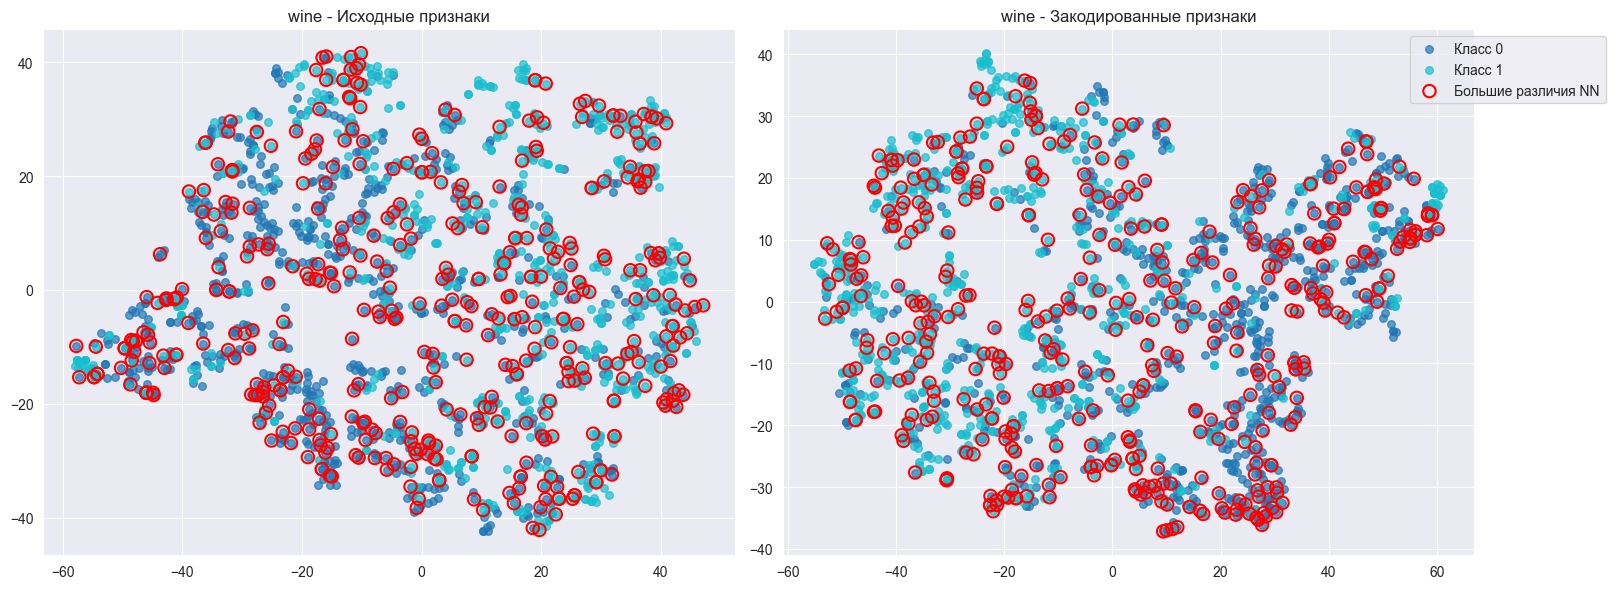


Анализ датасета: Pumpkin_Seeds
Epoch 1/50, Train Loss: 0.325089, Val Loss: 0.313232
Epoch 2/50, Train Loss: 0.279548, Val Loss: 0.328318
Epoch 3/50, Train Loss: 0.283256, Val Loss: 0.325707
Epoch 4/50, Train Loss: 0.248961, Val Loss: 0.307948
Epoch 5/50, Train Loss: 0.272931, Val Loss: 0.316551
Epoch 6/50, Train Loss: 0.257127, Val Loss: 0.297428
Epoch 7/50, Train Loss: 0.245967, Val Loss: 0.307113
Epoch 8/50, Train Loss: 0.255169, Val Loss: 0.303689
Epoch 9/50, Train Loss: 0.276478, Val Loss: 0.320478
Epoch 10/50, Train Loss: 0.267216, Val Loss: 0.312746
Epoch 11/50, Train Loss: 0.273142, Val Loss: 0.312140
Early stopping at epoch 11

Анализ с использованием метрики euclidean:
  Среднее соотношение пересечения: 0.5345
  Образцы с большими различиями: 670 (41.88%)
  Распределение меток в образцах с большими различиями:
    Метка 0: 48.81% (vs 52.00% в общем), соотношение: 0.94
    Метка 1: 51.19% (vs 48.00% в общем), соотношение: 1.07

Анализ с использованием метрики mahalanobis:
  Ср

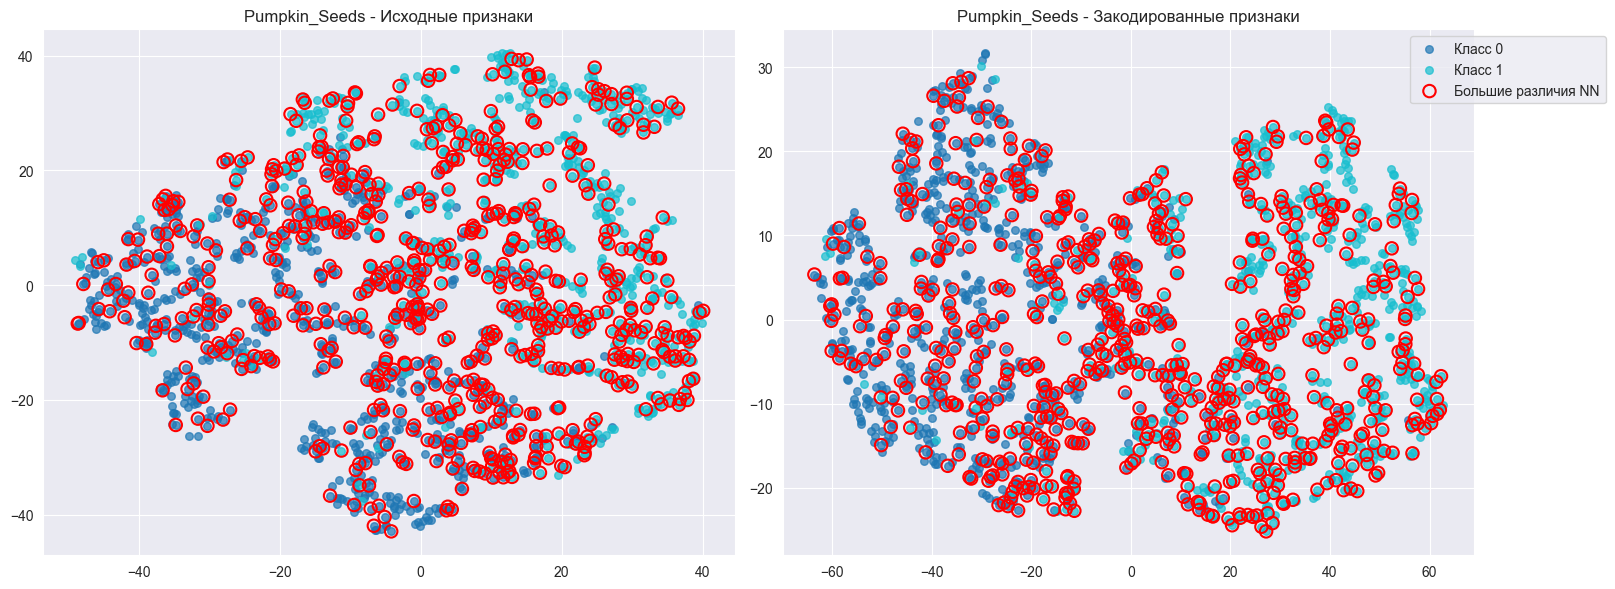


wine:
  euclidean mean overlap: 0.6241
  euclidean diff samples: 428 samples
  mahalanobis mean overlap: 0.5280
  mahalanobis diff samples: 725 samples

Pumpkin_Seeds:
  euclidean mean overlap: 0.5345
  euclidean diff samples: 670 samples
  mahalanobis mean overlap: 0.2834
  mahalanobis diff samples: 884 samples


In [13]:
datasets = ["wine", "Pumpkin_Seeds"]
all_results = {}

for dataset_name in datasets:
    try:
        results, _, _ = analyze_dataset(dataset_name)
        all_results[dataset_name] = results
    except Exception as e:
        print(f"Error analyzing dataset {dataset_name}: {e}")

for dataset_name, results in all_results.items():
    print(f"\n{dataset_name}:")
    for metric in ["euclidean", "mahalanobis"]:
        print(f"  {metric} mean overlap: {results['metrics'][metric]['mean_overlap']:.4f}")
        print(f"  {metric} diff samples: {len(results['metrics'][metric]['diff_samples'])} samples")

Результаты анализа wine и Pumpkin_Seeds показывают, что есть различия в структуре ближайших соседей между исходным и скрытым пространствами после кодирования моделью TabR. Для wine среднее пересечение ближайших соседей при использовании евклидовой метрики составляет 62.41%, что свидетельствует оь умеренной сохранности локальной структуры данных при переходе в скрытое пространство. Метрика Махаланобиса показывает более низкое среднее пересечение соседей для обоих датасетов (52.80% для wine и всего 28.34% для Pumpkin_Seeds) => есть трансформация структуры данных при учете ковариации признаков.
Для Pumpkin_Seeds различия в структуре соседей более выражены, чем для wine, мб из-за того, что в Pumpkin_Seeds есть более сложные нелинейные зависимости, которые TabR выявляет и преобразует в этом наборе данных.
Для Pumpkin_Seeds при использовании метрики Махаланобиса более половины образцов (55.25%) имеют существенные различия в структуре соседей, что может указывать на сильное преобразование данных энкодером TabR.
Модель TabR демонстрирует быструю сходимость при обучении с ранней остановкой на 12-й эпохе для wine и 11-й эпохе для Pumpkin_Seeds, достигая стабильных значений функции потерь.
Итого, выяснили, что TabR существенно трансформирует локальную структуру данных, особенно видно при использовании метрики Махаланобиса, кот учитывает ковариацию признаков.